In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import src.grimoire as Grimoire
from src.grimoire import By
import src.decks as Decks


In [2]:
commander = "Kodama of the West Tree"
# grim = Grimoire.Grimoire(omnicomprehensive=True)
# Decks.fetch(By.COMMANDER, commander,do_load=False,upper_limit=600)
grim = Grimoire.fetch(By.COMMANDER,commander)


Carico le carte dal grimorio di Kodama of the West Tree


In [3]:
from src.card import Filters
# Crea la matrice di correlazione
df = grim.dataframe( 
    positive_filters=[
        Filters.isLegalInCommander,
        Filters.isCreature,
        # Filters.isGreen
        # Filters.isColorless
    ], 
    negative_filters=[
        Filters.isToken
        # Filters.isLegendary
    ],
    additional_data={
        # "is_creature": lambda card: int(Type.Creature.name in card.types),
        # "#keywords" : lambda card: len(card.keywords),
        # "#words" : lambda card: card.text.count(' ')+1,
        # "is_green": lambda card: int(card.color_identity['G']),
        # "is_black": lambda card: int(card.color_identity['B']),
        # "is_colorless": lambda card: int(all(not v for v in card.color_identity.values())),
        "is_legendary": lambda card: int("Legendary" in card.super_types),
        "#act_abilities": lambda card: int(card.count_active_abilities()),
        "#trigg_abilities": lambda card: int(card.count_trigger_abilities()),
        "#mana_production": lambda card: int(card.count_mana_production())
    })

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_scaled = df.copy()
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
df_scaled[numeric_cols] =  scaler.fit_transform(df[numeric_cols])
correlation_matrix = df_scaled.corr()

In [5]:
grim.remove(9092494)

True

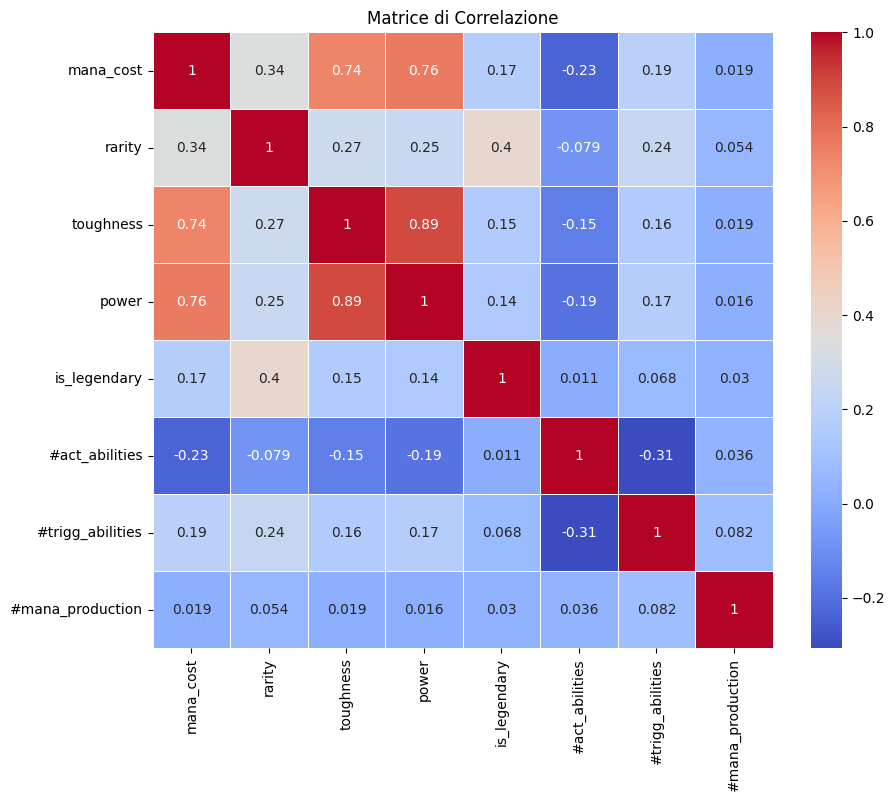

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
# Opzionalmente, crea una heatmap per visualizzare meglio la correlazione
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice di Correlazione')
plt.show()


In [7]:
vectors = grim.vectorize()

# def percentuale(count):
#     return round(count/len(grim)*100,2)

# print(f'Su un totale di {len(grim)} carte:')vectors
# for term, count in vectors.items():
#     space = ' ' if len(str(percentuale(count))) <5 else ''
#     print(f'{space}{percentuale(count)}%: {count} sono {term}')

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np


# Funzione per aggiornare la heatmap
def update_heatmap(limit):
    # Crea una maschera booleana per nascondere le annotazioni non significative
    mask_annot = (correlation_matrix < -limit) | (correlation_matrix > limit)

    # Crea una matrice di annotazioni, sostituendo i valori non significativi con NaN
    annot = np.where(mask_annot, np.round(correlation_matrix, 2), np.nan)

    # Stampa la heatmap senza annotazioni per le celle non significative
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=annot, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8}, mask=np.isnan(annot))
    plt.title(f'Heatmap with Limit: {limit}')
    plt.show()

# Crea un widget per limit
limit_slider = widgets.FloatSlider(value=0.15, min=0.00, max=0.23, step=0.001, description='Limit:')


# # Mostra la heatmap iniziale
# update_heatmap(limit_slider.value)

# Collega il widget alla funzione di aggiornamento
widgets.interactive(update_heatmap, limit=limit_slider)

interactive(children=(FloatSlider(value=0.15, description='Limit:', max=0.23, step=0.001), Output()), _dom_cla…

In [ ]:
from src.similarity import SimilarityMethod as SimMeth
import importlib
importlib.reload(Grimoire)

pairwise_matrix = Grimoire.partial_vectors_matrix(grim)
presence_matrix = grim.vectorize().values()

AttributeError: module 'src.grimoire' has no attribute 'partial_vectors_matrix'

In [ ]:

methods = [SimMeth.COSINE, SimMeth.EUCLIDEAN, SimMeth.PEARSON_CORRELATION]
matrices, times = Grimoire.similarity_pairwise_matrix(pairwise_matrix,methods)

/home/axten/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2991: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/axten/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/axten/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/axten/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/axten/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
print(times)

[5.721561431884766, 2.6408402919769287, 11.385042667388916]


In [ ]:
for i, matrix in enumerate(matrices):
    print(f"{matrix}\n\n")

[[1.         0.09660918 0.07794838 ... 0.12080809 0.16329932 0.10025608]
 [0.09660918 1.         0.04034212 ... 0.20841376 0.15494495 0.20754981]
 [0.07794838 0.04034212 1.         ... 0.13078881 0.07955573 0.11163998]
 ...
 [0.12080809 0.20841376 0.13078881 ... 1.         0.34249789 0.2883749 ]
 [0.16329932 0.15494495 0.07955573 ... 0.34249789 1.         0.24849977]
 [0.10025608 0.20754981 0.11163998 ... 0.2883749  0.24849977 1.        ]]


[[ 0.         11.44552314 11.91637529 ... 11.44552314 11.09053651
  11.22497216]
 [11.44552314  0.         11.95826074 ... 10.67707825 10.95445115
  10.34408043]
 [11.91637529 11.95826074  0.         ... 11.53256259 11.78982612
  11.3137085 ]
 ...
 [11.44552314 10.67707825 11.53256259 ...  0.          9.79795897
   9.94987437]
 [11.09053651 10.95445115 11.78982612 ...  9.79795897  0.
  10.14889157]
 [11.22497216 10.34408043 11.3137085  ...  9.94987437 10.14889157
   0.        ]]


[[        nan -0.90332718 -0.92202309 ... -0.87918882 -0.83666003
  

In [ ]:
matrix = matrices[0]
rows, cols = matrix.shape

if rows != cols:
    raise ValueError("La matrice non è quadrata.")
if not (matrix == matrix.T).all():
    raise ValueError("La matrice non è simmetrica.")
if (matrix < 0).any():
    raise ValueError("La matrice contiene valori negativi.")

In [ ]:

# import imageio.v2 as imageio
# # Definisci i limiti per la GIF
# limits = np.arange(0, 0.24, 0.01)

# # Lista per salvare i frame
# frames = []

# # Genera i frame
# for limit in limits:
#     plt.figure(figsize=(10, 8))
    
#     # Crea una maschera booleana per nascondere le annotazioni non significative
#     mask_annot = (correlation_matrix < -limit) | (correlation_matrix > limit)

#     # Crea una matrice di annotazioni
#     annot = np.where(mask_annot, np.round(correlation_matrix, 2), np.nan)

#     # Stampa la heatmap
#     sns.heatmap(correlation_matrix, annot=annot, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8}, mask=np.isnan(annot))
#     plt.title(f'Heatmap with Limit: {limit:.2f}')
    
#     # Salva il frame come immagine
#     plt.savefig(f'frame_{limit:.2f}.png')
#     plt.close()

#     # Aggiungi il frame alla lista
#     frames.append(imageio.imread(f'frame_{limit:.2f}.png'))

# # Crea una GIF animata
# imageio.mimsave('heatmap_animation.gif', frames, duration=4)

# # Rimuovi le immagini temporanee (opzionale)
# import os
# for limit in limits:
#     os.remove(f'frame_{limit:.2f}.png')

# print("GIF animata creata: heatmap_animation.gif")

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform, pdist

deck_ids = list(grim.get_all_deck_ids())
threshold = 0.4
distanze = 1 - matrix

model = AgglomerativeClustering(distance_threshold=threshold, n_clusters=None)
labels = model.fit_predict(distanze)
distanze_condensate = sch.linkage(squareform(distanze), method='complete')

# Numero di cluster
n_clusters = len(set(labels))
print(f"Numero di cluster: {n_clusters}")

# # Visualizza il dendrogramma
# plt.figure(figsize=(80, 7))
# dendrogram = sch.dendrogram(distanze_condensate, labels=deck_ids)
# plt.axhline(y=threshold, color='r', linestyle='--')  # Imposta una soglia per tagliare i cluster
# plt.xlabel('Mazzi di carte')  # Aggiungi una label all'asse x
# plt.ylabel('Distanza')  # Aggiungi una label all'asse y
# plt.show()

Numero di cluster: 578


/home/axten/.local/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Numero di cluster dal dendrogramma: 525
Numero di cluster dal dendrogramma: 543
Numero di cluster dal dendrogramma: 538
Numero di cluster dal dendrogramma: 543
Numero di cluster dal dendrogramma: 527
Numero di cluster dal dendrogramma: 528


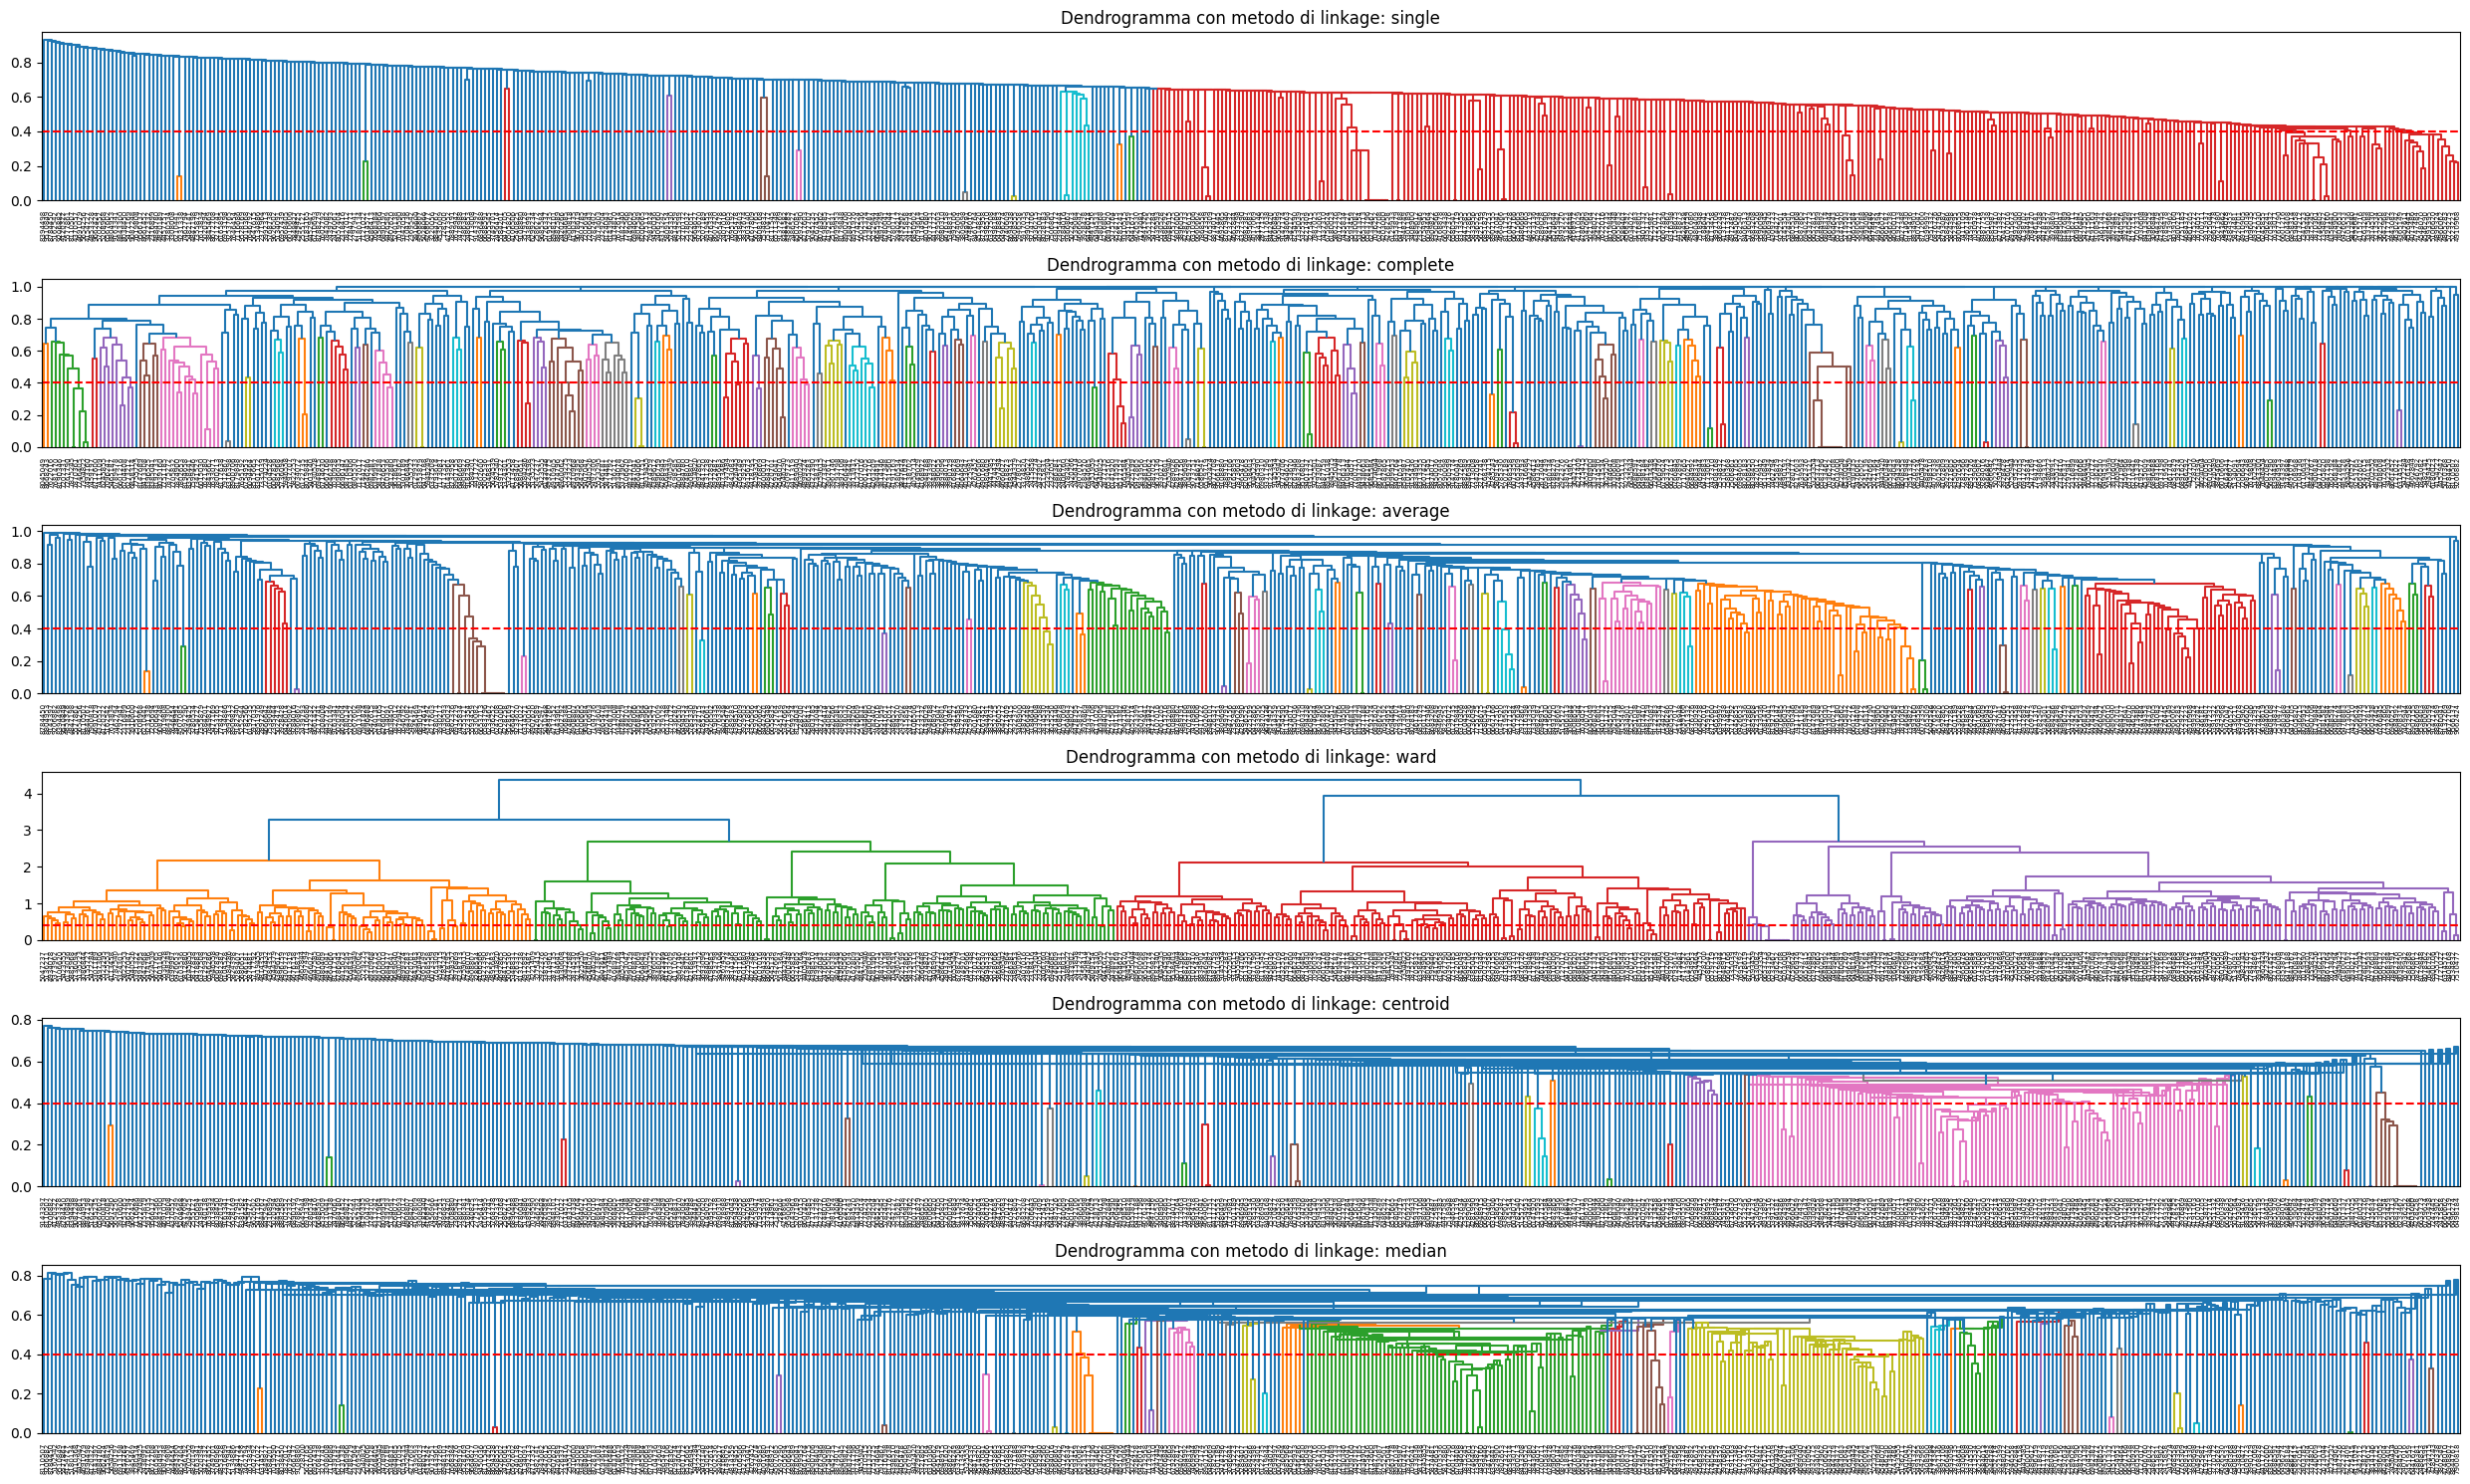

In [ ]:

# Lista dei metodi di linkage
linkage_methods = ['single', 'complete', 'average', 'ward', 'centroid', 'median']

# Crea i grafici
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(25, 15))  # Un grafico per ogni metodo di linkage

for i, method in enumerate(linkage_methods):
    # Calcola la matrice di linkage per il metodo corrente
    distanze_condensate = sch.linkage(squareform(distanze), method=method)
    
    # Disegna il dendrogramma
    sch.dendrogram(distanze_condensate, ax=axs[i], labels=deck_ids)
    axs[i].set_title(f'Dendrogramma con metodo di linkage: {method}')
    axs[i].axhline(y=threshold, color='r', linestyle='--')  # Imposta una soglia per tagliare i cluster

    # Taglia il dendrogramma a una certa altezza
    cluster_labels = sch.fcluster(distanze_condensate, t=threshold, criterion='distance')

    # Calcola il numero di cluster dal dendrogramma
    n_clusters_from_dendrogram = len(set(cluster_labels))
    print(f"Numero di cluster dal dendrogramma: {n_clusters_from_dendrogram}")

plt.tight_layout()  # Ottimizza la disposizione
plt.show()

In [ ]:
from scipy.spatial.distance import cdist
from src.card import Card
importlib.reload(Grimoire)

def predict_with_model(model, parz, full_data, threshold=0.5):
    """
    Usa il modello di clustering addestrato per predire i valori più probabili per riempire il vettore 'parz'.
    
    Args:
    - model: il modello di clustering agglomerativo già addestrato
    - parz: il vettore parzialmente riempito (array booleano)
    - full_data: il dataset originale usato per addestrare il modello, come array 2D
    
    Returns:
    - predizione dei valori 'uno' aggiuntivi più probabili
    """
    # Trova il cluster per il vettore parziale `parz`
    parz_array = np.array(parz)
    parz_reshaped = parz_array.reshape(1, -1)
    distances = cdist(parz_reshaped, full_data, metric='euclidean').flatten()
    nearest_vector_index = np.argmin(distances)

    # Trova il cluster di appartenenza del vettore più simile
    cluster_label = model.labels_[nearest_vector_index]

    # Filtra i vettori nello stesso cluster e calcola la media per ottenere la probabilità di ciascun 'uno'
    cluster_vectors = full_data[model.labels_ == cluster_label]
    prob_one = cluster_vectors.mean(axis=0)

    # Ordina gli indici per probabilità decrescente e restituisci i più probabili
    sorted_indices = np.argsort(prob_one)[::-1]
    likely_ones = sorted_indices[prob_one[sorted_indices] >= threshold]  # Considera probabili solo valori >0.5

    return likely_ones

partial = [
    Card("Kodama of the West Tree"),
    Card("Roaring Earth"),
    Card("Inspiring Call"),
    Card("Hardened Scales"),
    Card("Evolution Sage")
    ]
predizione = predict_with_model(model, grim.partial_vector(partial), partial_vectors_matrix)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (597, 597, 2) + inhomogeneous part.

In [ ]:

# Stampa le etichette dei cluster per ogni punto
print("Etichette dei cluster:", labels)

# 4. Visualizza i dati e i cluster
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='rainbow')
plt.title('Agglomerative Hierarchical Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# 5. Visualizzazione del dendrogramma
linked = linkage(data, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Indice dei punti')
plt.ylabel('Distanza')
plt.show()

Etichette dei cluster: [503 433 293 506 557 444 485 543 523 459 478 509 315 541 467 424 428 313
 355 422 342 369 423 339 343 387 430 531 359 565  41 493 377 401 351 520
 371 547 432 570 453 514 483 519 370 368 301 568 435 573 544 389 567 473
 392 484 527 518 298 464 336 395 431 562 317 365 554 556 470 440 411 292
 530   0 344 305 366 511 490 399 472 362 517 436 404 488 323 537 427 524
 491 420 381   5 538 303 334 494 479 417 539 335 548 516 437 487 533 540
 167 341 384 532 345 363 457 558 497 318 413 300 449 429 396 307 526   1
 197 306 482 416 504  10 310 419 258 454 528  14 525 367   0 261 505 513
 314 325 529   9 183 263 560 468   3 418 546 319 566 421 480 337 410 379
 545 462 271 426 515 316 469 553 282 569   1   4 378 309 522 208 330 373
 246 290 278 188 272 211 451 415 561 295 361 439 499 441 226 542 438 360
 308 269 402 256 481 536   9 304 409 352 270 322  20 475 434 348 239 534
 353 455 414 577 496 405 507 571 154 241 412 492 276 200 204 346 326 302
 179 333 245 549 356  21 552

NameError: name 'data' is not defined

In [ ]:
# Controlla se ci sono valori negativi
if np.any(matrix > 1):
    print("La matrice di distanze contiene valori negativi.")

In [ ]:

from sklearn.metrics import silhouette_score
# Calcola il silhouette score
score = silhouette_score(distanze, labels, metric='precomputed')
print(f'Silhouette Score: {score:.3f}')

In [ ]:

from scipy.cluster.hierarchy import linkage

# Clustering agglomerativo
Z = linkage(distanze, method='average')

# Calcola le distanze per il metodo del gomito
max_distanze = []
for i in range(1, len(matrix)):
    # Aggiungi la distanza massima dal dendrogramma
    max_distanze.append(max(Z[:i, 2]))

# Grafico del metodo del gomito
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(matrix)), max_distanze, marker='o')
plt.title('Metodo del Gomito per Clustering Agglomerativo')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Distanza Massima')
plt.grid()
plt.show()